In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from pathlib import Path
import pickle
import pandas as pd
import numpy as np
from scipy import stats

import pandas_datareader.data as web

from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import roc_auc_score

import statsmodels.formula.api as smf

import matplotlib.pyplot as plt
from matplotlib import animation
import seaborn as sns
from IPython.display import HTML
sns.set_style('whitegrid')
data_path = Path('data')
fig_path = Path('figures')
model_path = Path('models')
for p in [data_path, fig_path, model_path]:
    if not p.exists():
        p.mkdir()

import pymc3 as pm
from pymc3.variational.callbacks import CheckParametersConvergence
import arviz
import theano


WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
#  source: https://fred.stlouisfed.org/
indicators = ['JHDUSRGDPBR', 'T10Y3M', 'NFCI', 'NFCINONFINLEVERAGE', 'UMCSENT']
var_names = ['recession', 'yield_curve', 'financial_conditions', 'leverage', 'sentiment']
features = var_names[1:]
label = var_names[0]
# leading indicator for Recession: Yield Curve, Financial Conditions, Leverage, Sentiment
var_display = ['Recession', 'Yield Curve', 'Financial Conditions', 'Leverage', 'Sentiment']
col_dict = dict(zip(var_names, var_display))
data = (web.DataReader(indicators, 'fred', 1980, 2023).ffill().resample('M').last().dropna())
data.columns = var_names
data.tail()

,recession,yield_curve,financial_conditions,leverage,sentiment
DATE,,,,,
2022-09-30,0.0,0.50,-0.09287,-0.83370,58.6
2022-10-31,0.0,-0.12,-0.12911,-0.78697,59.9
2022-11-30,0.0,-0.69,-0.19703,-0.74524,56.8
2022-12-31,0.0,-0.54,-0.23491,-0.70274,59.7
2023-01-31,0.0,-0.54,-0.23491,-0.70274,64.9


In [3]:
data.loc[:, features] = scale(data.loc[:, features])
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 493 entries, 1982-01-31 to 2023-01-31
Freq: M
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   recession             493 non-null    float64
 1   yield_curve           493 non-null    float64
 2   financial_conditions  493 non-null    float64
 3   leverage              493 non-null    float64
 4   sentiment             493 non-null    float64
dtypes: float64(5)
memory usage: 23.1 KB


In [4]:
data.tail()

,recession,yield_curve,financial_conditions,leverage,sentiment
DATE,,,,,
2022-09-30,0.0,-1.068749,0.268597,-0.784709,-2.259614
2022-10-31,0.0,-1.621684,0.213401,-0.740180,-2.155632
2022-11-30,0.0,-2.130027,0.109953,-0.700417,-2.403589
2022-12-31,0.0,-1.996252,0.052259,-0.659919,-2.171629
2023-01-31,0.0,-1.996252,0.052259,-0.659919,-1.755702


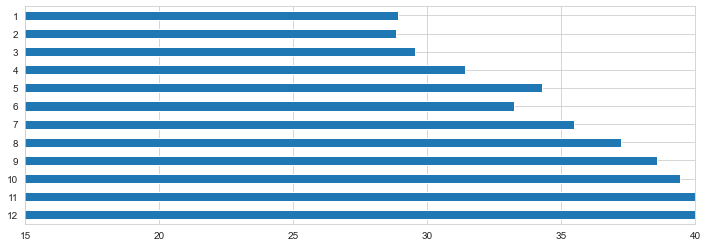

In [5]:
mi = []
months = list(range(1, 25)) # to chk the mutual information btw recession and other variables in 1~24 months
for month in months:
    df_ = data.copy()
    df_[label] = df_[label].shift(-month)
    df_ = df_.dropna()
    # mutual_info_classif: Estimate mutual information for a discrete target variable
    mi.append(mutual_info_classif(df_.loc[:, features], df_[label]))
mi = pd.DataFrame(mi, columns=features, index=months)
mi.sum(1).mul(100).iloc[:12].sort_index(ascending=False).plot.barh(figsize=(12, 4), xlim=(15, 40));

In [6]:
mi.tail()

,yield_curve,financial_conditions,leverage,sentiment
20,0.097973,0.059683,0.169686,0.023924
21,0.098291,0.065038,0.169057,0.036772
22,0.098740,0.046201,0.152678,0.038076
23,0.063146,0.051980,0.127839,0.035501
24,0.044935,0.050771,0.119719,0.027558


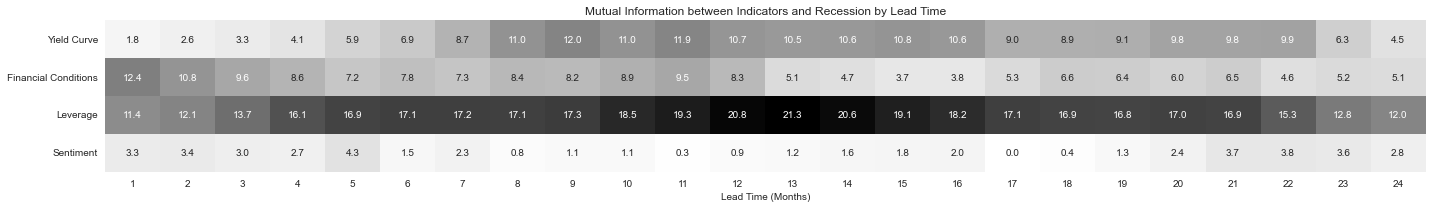

In [7]:
fig, ax = plt.subplots(figsize=(20, 3))
sns.heatmap(mi.rename(columns=col_dict).T*100, cmap='Greys', ax=ax, annot=True, fmt='.1f', cbar=False)
ax.set_xlabel('Lead Time (Months)')
ax.set_title('Mutual Information between Indicators and Recession by Lead Time')
fig.tight_layout()

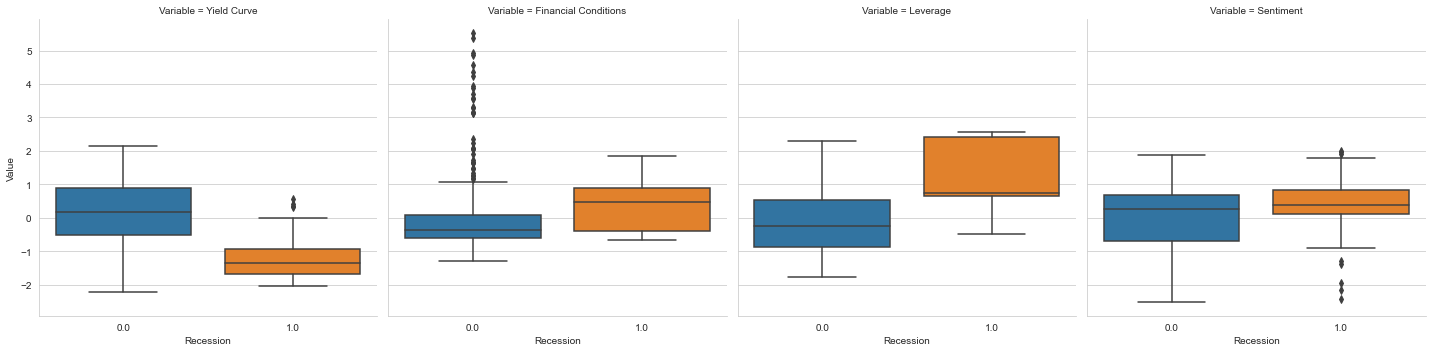

In [8]:
data[label] = data[label].shift(-12) # to chk the estimation for more short term(12m) to adjust the balance btw NFCI & Yield Curve
data = data.dropna()
data_ = pd.melt(data.rename(columns=col_dict), id_vars='Recession').rename(columns=str.capitalize)
g = sns.catplot(x='Recession', y='Value', col='Variable', data=data_, kind='box');

In [9]:
X = data.loc[:, features]
y = data[label]
y.value_counts()

0.0    427
1.0     54
Name: recession, dtype: int64

In [10]:
data.to_csv('data/recessions.csv')

In [11]:
data = pd.read_csv('data/recessions.csv', index_col=0)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 481 entries, 1982-01-31 to 2022-01-31
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   recession             481 non-null    float64
 1   yield_curve           481 non-null    float64
 2   financial_conditions  481 non-null    float64
 3   leverage              481 non-null    float64
 4   sentiment             481 non-null    float64
dtypes: float64(5)
memory usage: 22.5+ KB


In [68]:
data.tail(10)

,recession,yield_curve,financial_conditions,leverage,sentiment
DATE,,,,,
2021-04-30,0.0,-0.052063,-0.640877,-1.627457,0.115972
2021-05-31,0.0,-0.114491,-0.663647,-1.633469,-0.315953
2021-06-30,0.0,-0.266102,-0.652940,-1.631440,-0.107989
2021-07-31,0.0,-0.462304,-0.588773,-1.596831,-0.451929
2021-08-31,0.0,-0.390958,-0.569856,-1.538019,-1.323777
2021-09-30,0.0,-0.194755,-0.583198,-1.457615,-1.123812
2021-10-31,0.0,-0.176919,-0.548625,-1.352788,-1.211797
2021-11-30,0.0,-0.283938,-0.421829,-1.289069,-1.555737
2021-12-31,0.0,-0.212592,-0.430175,-1.243359,-1.299782


In [12]:
simple_model = 'recession ~ yield_curve + leverage'
full_model =  simple_model + ' + financial_conditions + sentiment'

In [13]:
with pm.Model() as manual_logistic_model:
    # random variables for coefficients with uninformative priors for each parameter

    intercept = pm.Normal('intercept', 0, sd=100)
    beta_1 = pm.Normal('beta_1', 0, sd=100)
    beta_2 = pm.Normal('beta_2', 0, sd=100)

    # Transform random variables into vector of probabilities p(y_i=1) according to logistic regression model specification.
    likelihood = pm.invlogit(intercept + beta_1 * data.yield_curve + beta_2 * data.leverage)

    # Bernoulli random vector with probability of success given by sigmoid function and actual data as observed
    pm.Bernoulli(name='logit', p=likelihood, observed=data.recession)
manual_logistic_model.model

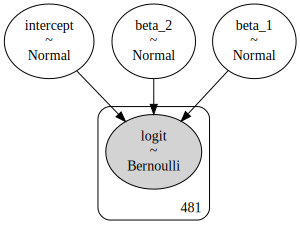

In [14]:
pm.model_to_graphviz(manual_logistic_model)

In [15]:
# opionally: persist
# graph = pm.model_to_graphviz(manual_logistic_model)
# graph.save('log_reg.dot')

with manual_logistic_model:
    # compute maximum a-posteriori estimate
    # for logistic regression weights
    manual_map_estimate = pm.find_MAP()

In [16]:
def print_map(result):
    return pd.Series({k: np.asscalar(v) for k, v in result.items()})

print_map(manual_map_estimate)

intercept   -3.713445
beta_1      -1.693003
beta_2       1.296084
dtype: float64

In [17]:
with pm.Model() as logistic_model:
    # GLM: Generalized Linear Models
    pm.glm.GLM.from_formula(simple_model, data, family=pm.glm.families.Binomial())

The glm module is deprecated and will be removed in version 4.0
We recommend to instead use Bambi https://bambinos.github.io/bambi/


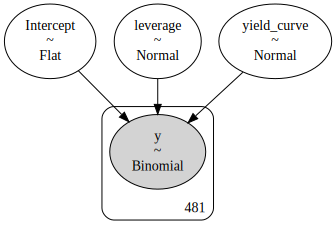

In [18]:
pm.model_to_graphviz(logistic_model)

In [19]:
with logistic_model:
    map_estimate = pm.find_MAP()

In [20]:
model = smf.logit(formula=simple_model, data=data)
result = model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.192901
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:              recession   No. Observations:                  481
Model:                          Logit   Df Residuals:                      478
Method:                           MLE   Df Model:                            2
Date:                Thu, 21 Sep 2023   Pseudo R-squ.:                  0.4508
Time:                        19:28:33   Log-Likelihood:                -92.785
converged:                       True   LL-Null:                       -168.94
Covariance Type:            nonrobust   LLR p-value:                 8.441e-34
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -3.7135      0.361    -10.293      0.000      -4.421      -3.006
yield_curve    -1.6930    

In [21]:
print_map(map_estimate)

Intercept     -3.713510
yield_curve   -1.693042
leverage       1.296106
dtype: float64

In [22]:
result.params

Intercept     -3.713511
yield_curve   -1.693043
leverage       1.296105
dtype: float64

In [23]:
# Markov Chain Monte Carlo
def plot_traces(traces, burnin=2000):
    summary = arviz.summary(traces[burnin:])['mean'].to_dict()
    ax = arviz.plot_trace(traces[burnin:], figsize=(15, len(traces.varnames)*1.5), lines=summary)

    for i, mn in enumerate(summary.values()):
        ax[i, 0].annotate(f'{mn:.2f}', xy=(mn, 0), xycoords='data', xytext=(5, 10), textcoords='offset points', rotation=90, va='bottom', fontsize='large', color='#AA0022')

In [24]:
# Define the Model
with pm.Model() as logistic_model:
    pm.glm.GLM.from_formula(formula=full_model, data=data, family=pm.glm.families.Binomial())

The glm module is deprecated and will be removed in version 4.0
We recommend to instead use Bambi https://bambinos.github.io/bambi/


In [25]:
logistic_model.basic_RVs

[Intercept ~ Flat,
 yield_curve ~ Normal,
 leverage ~ Normal,
 financial_conditions ~ Normal,
 sentiment ~ Normal,
 y ~ Binomial]

In [26]:
with logistic_model:
    trace_mh = pm.sample(tune=1000, draws=5000, step=pm.Metropolis(), cores=4, idata_kwargs = {'log_likelihood': True})

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sentiment]
>Metropolis: [financial_conditions]
>Metropolis: [leverage]
>Metropolis: [yield_curve]
>Metropolis: [Intercept]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 40 seconds.
The number of effective samples is smaller than 10% for some parameters.


In [27]:
# plot_traces(trace_mh, burnin=0)

In [28]:
pm.trace_to_dataframe(trace_mh).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Intercept             20000 non-null  float64
 1   yield_curve           20000 non-null  float64
 2   leverage              20000 non-null  float64
 3   financial_conditions  20000 non-null  float64
 4   sentiment             20000 non-null  float64
dtypes: float64(5)
memory usage: 781.4 KB


In [29]:
# Continue Training
with logistic_model:
    trace_mh = pm.sample(draws=100000, step=pm.Metropolis(), trace=trace_mh)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sentiment]
>Metropolis: [financial_conditions]
>Metropolis: [leverage]
>Metropolis: [yield_curve]
>Metropolis: [Intercept]


Sampling 4 chains for 1_000 tune and 105_000 draw iterations (4_000 + 420_000 draws total) took 294 seconds.
The number of effective samples is smaller than 10% for some parameters.


In [30]:
# plot_traces(trace_mh, burnin=0)

In [31]:
# optionally: persist
with open('logistic_model_mh.pkl', 'wb') as buff:
    pickle.dump({'model': logistic_model, 'trace': trace_mh}, buff)

In [32]:
# optionally: restore persisted model
# with open('logistic_model_mh.pkl', 'rb') as buff:
#     pickled_data = pickle.load(buff)

# logistic_model, trace_mh = pickled_data['model'], pickled_data['trace']
arviz.summary(trace_mh)

Got error No model on context stack. trying to find log_likelihood in translation.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-4.761,0.548,-5.787,-3.749,0.007,0.005,6125.0,11924.0,1.0
yield_curve,-1.803,0.318,-2.411,-1.219,0.003,0.002,13100.0,22937.0,1.0
leverage,1.603,0.310,1.031,2.192,0.003,0.002,8955.0,17071.0,1.0
financial_conditions,0.926,0.240,0.465,1.368,0.002,0.002,10063.0,19938.0,1.0
sentiment,0.821,0.322,0.231,1.442,0.003,0.002,9660.0,18019.0,1.0


In [33]:
draws = 100
tune = 1000
with logistic_model:
    trace_NUTS = pm.sample(draws=draws, tune=tune, init='adapt_diag', chains=4, cores=1, random_seed=42)

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [sentiment, financial_conditions, leverage, yield_curve, Intercept]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 10 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.


In [34]:
trace_df = pm.trace_to_dataframe(trace_NUTS).assign(
    chain=lambda x: x.index // draws)
trace_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Intercept             400 non-null    float64
 1   yield_curve           400 non-null    float64
 2   leverage              400 non-null    float64
 3   financial_conditions  400 non-null    float64
 4   sentiment             400 non-null    float64
 5   chain                 400 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 18.9 KB


In [69]:
trace_df.tail(10)

,Intercept,yield_curve,leverage,financial_conditions,sentiment
990,-4.052986,-1.467028,1.435031,0.792436,0.672373
991,-3.836882,-1.467028,1.265056,0.792436,0.672373
992,-3.836882,-1.467028,1.265056,0.884414,0.672373
993,-4.096461,-1.467028,1.478408,0.547377,0.672373
994,-4.209938,-1.467028,1.478408,0.547377,0.672373
995,-4.209938,-1.588585,1.478408,0.547377,0.672373
996,-3.926004,-1.588585,1.478408,0.547377,0.672373
997,-3.926004,-1.588585,1.478408,0.547377,0.672373
998,-4.506736,-1.588585,1.478408,0.547377,0.672373
999,-4.417829,-1.588585,1.478408,0.547377,0.815485


In [35]:
# plot_traces(trace_NUTS, burnin=0)

In [36]:
draws = 50000
chains = 4
with logistic_model:
    trace_NUTS = pm.sample(draws=draws, tune=tune, init='adapt_diag', trace=trace_NUTS, chains=chains, cores=1, random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [sentiment, financial_conditions, leverage, yield_curve, Intercept]


Sampling 4 chains for 1_000 tune and 50_100 draw iterations (4_000 + 200_400 draws total) took 408 seconds.


In [37]:
# plot_traces(trace_NUTS, burnin=1000)

In [38]:
# Persist Results
with open('logistic_model_nuts.pkl', 'wb') as buff:
    pickle.dump({'model': logistic_model, 'trace': trace_NUTS}, buff)

In [39]:
# with open('logistic_model_nuts.pkl', 'rb') as buff:
#     pickled_data = pickle.load(buff)

# logistic_model, trace_NUTS = pickled_data['model'], pickled_data['trace']

In [40]:
# Combine Traces
df = pm.trace_to_dataframe(trace_NUTS).iloc[200:].reset_index(drop=True).assign(chain=lambda x: x.index // draws)
trace_df = pd.concat([trace_df.assign(samples=100), df.assign(samples=len(df) + len(trace_df))])
trace_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200600 entries, 0 to 200199
Data columns (total 7 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Intercept             200600 non-null  float64
 1   yield_curve           200600 non-null  float64
 2   leverage              200600 non-null  float64
 3   financial_conditions  200600 non-null  float64
 4   sentiment             200600 non-null  float64
 5   chain                 200600 non-null  int64  
 6   samples               200600 non-null  int64  
dtypes: float64(5), int64(2)
memory usage: 12.2 MB


In [41]:
# Visualize both traces
trace_df_long = pd.melt(trace_df, id_vars=['samples', 'chain'])
trace_df_long.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1003000 entries, 0 to 1002999
Data columns (total 4 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   samples   1003000 non-null  int64  
 1   chain     1003000 non-null  int64  
 2   variable  1003000 non-null  object 
 3   value     1003000 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 30.6+ MB


In [70]:
trace_df_long.tail(10)

,samples,chain,variable,value
1002990,200600,4,sentiment,0.055076
1002991,200600,4,sentiment,0.785997
1002992,200600,4,sentiment,0.816272
1002993,200600,4,sentiment,0.510965
1002994,200600,4,sentiment,0.627919
1002995,200600,4,sentiment,0.709843
1002996,200600,4,sentiment,0.430667
1002997,200600,4,sentiment,0.842287
1002998,200600,4,sentiment,0.399907
1002999,200600,4,sentiment,0.282191


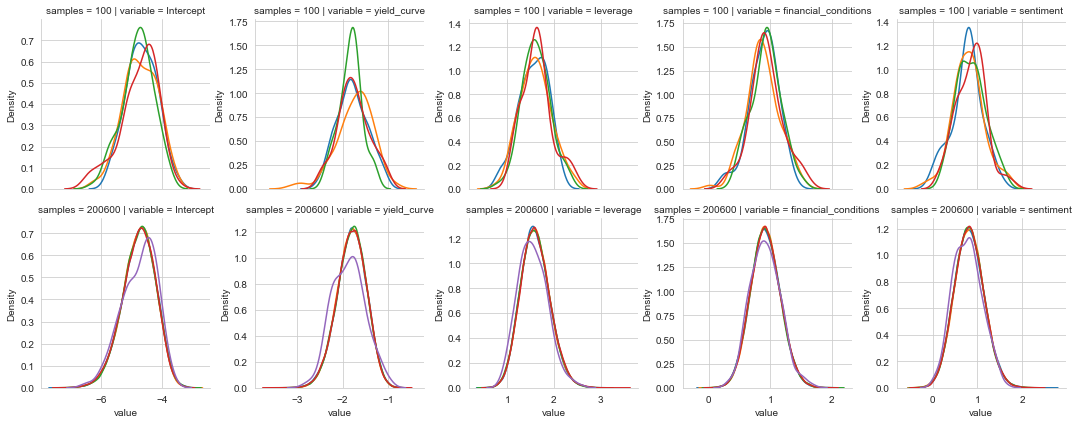

In [42]:
g = sns.FacetGrid(trace_df_long, col='variable', row='samples', hue='chain', sharex='col', sharey=False)
g = g.map(sns.distplot, 'value', hist=False, rug=False);

In [43]:
model = smf.logit(formula=full_model, data=data)
result = model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.176067
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:              recession   No. Observations:                  481
Model:                          Logit   Df Residuals:                      476
Method:                           MLE   Df Model:                            4
Date:                Thu, 21 Sep 2023   Pseudo R-squ.:                  0.4987
Time:                        19:43:41   Log-Likelihood:                -84.688
converged:                       True   LL-Null:                       -168.94
Covariance Type:            nonrobust   LLR p-value:                 2.190e-35
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -4.5702      0.521     -8.765      0.000      -5.592      -3.548

In [44]:
# arviz.summary(trace_NUTS).assign(statsmodels=result.params).to_csv(model_path / 'trace_nuts.csv')

In [45]:
arviz.summary(trace_NUTS).assign(statsmodels=result.params)

Got error No model on context stack. trying to find log_likelihood in translation.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,statsmodels
Intercept,-4.760,0.551,-5.798,-3.754,0.002,0.001,72292.0,87238.0,1.0,-4.570170
yield_curve,-1.805,0.323,-2.408,-1.200,0.001,0.001,117294.0,109560.0,1.0,-1.727536
leverage,1.602,0.314,1.028,2.202,0.001,0.001,88828.0,100651.0,1.0,1.536765
financial_conditions,0.925,0.243,0.465,1.380,0.001,0.001,86377.0,100688.0,1.0,0.894004
sentiment,0.818,0.329,0.209,1.444,0.001,0.001,81991.0,96169.0,1.0,0.776710


In [46]:
# Computing Credible Intervals
def get_credible_int(trace, param):
    b = trace[param]
    lb, ub = np.percentile(b, 2.5), np.percentile(b, 97.5)
    lb, ub = np.exp(lb), np.exp(ub)
    return b, lb, ub
b = trace_NUTS['yield_curve']
lb, ub = np.percentile(b, 2.5), np.percentile(b, 97.5)
lb, ub = np.exp(lb), np.exp(ub)
print(f'P({lb:.3f} < Odds Ratio < {ub:.3f}) = 0.95')

P(0.085 < Odds Ratio < 0.299) = 0.95


In [47]:
b, lb, ub = get_credible_int(trace_NUTS, 'yield_curve')
print(f'P({lb:.3f} < Odds Ratio < {ub:.3f}) = 0.95')

P(0.085 < Odds Ratio < 0.299) = 0.95


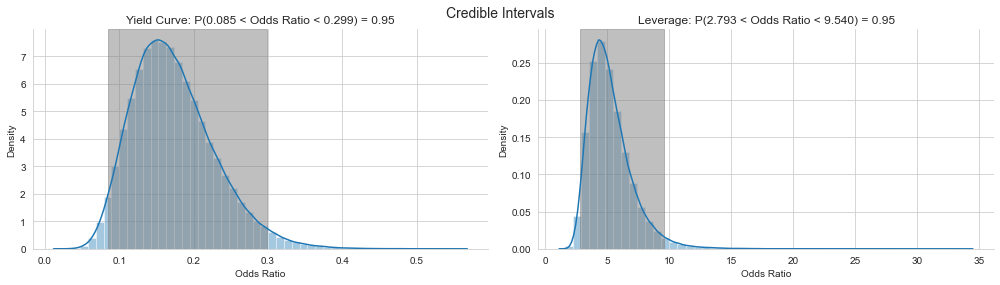

In [48]:
fig, axes = plt.subplots(figsize=(14, 4), ncols=2)
b, lb, ub = get_credible_int(trace_NUTS, 'yield_curve')
sns.distplot(np.exp(b), axlabel='Odds Ratio', ax=axes[0])
axes[0].set_title(f'Yield Curve: P({lb:.3f} < Odds Ratio < {ub:.3f}) = 0.95')
axes[0].axvspan(lb, ub, alpha=0.5, color='gray')

b, lb, ub = get_credible_int(trace_NUTS, 'leverage')
sns.distplot(np.exp(b), axlabel='Odds Ratio', ax=axes[1])
axes[1].set_title(f'Leverage: P({lb:.3f} < Odds Ratio < {ub:.3f}) = 0.95')
axes[1].axvspan(lb, ub, alpha=0.5, color='gray')

fig.suptitle('Credible Intervals', fontsize=14)
sns.despine()
fig.tight_layout()
fig.subplots_adjust(top=.9);

In [49]:
with logistic_model:
    callback = CheckParametersConvergence(diff='absolute')
    approx = pm.fit(n=100000,
                    callbacks=[callback])

Finished [100%]: Average Loss = 120.36


In [50]:
# Persist Result
# optional
# with open(logistic_model_advi.pkl', 'wb') as buff:
#     pickle.dump({'model': logistic_model,
#                  'approx': approx}, buff)

In [51]:
trace_advi = approx.sample(10000)
arviz.summary(trace_advi)

Got error No model on context stack. trying to find log_likelihood in translation.
arviz - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-4.708,0.221,-5.124,-4.293,0.002,0.002,10168.0,9879.0,NaN
yield_curve,-1.787,0.187,-2.137,-1.436,0.002,0.001,9930.0,9385.0,NaN
leverage,1.574,0.183,1.224,1.912,0.002,0.001,9864.0,9020.0,NaN
financial_conditions,0.912,0.171,0.587,1.230,0.002,0.001,9852.0,9719.0,NaN
sentiment,0.798,0.198,0.416,1.163,0.002,0.001,9924.0,9427.0,NaN


In [52]:
arviz.summary(trace_advi).to_csv(model_path / 'trace_advi.csv')

Got error No model on context stack. trying to find log_likelihood in translation.
arviz - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)


In [53]:
# Energy Plot
# arviz.plot_energy(trace_NUTS);

In [54]:
# Forest Plot
# arviz.plot_forest(trace_NUTS);

In [55]:
# fig, axes = plt.subplots(ncols=2, figsize=(14, 4))
# arviz.plot_forest(trace_NUTS, ax=axes[0])
# axes[0].set_title('Forest Plot')
# 
# arviz.plot_energy(trace_NUTS, ax=axes[1])
# axes[1].set_title('Energy Plot')
# 
# fig.tight_layout();

In [56]:
# Posterior Predictive Checks
ppc = pm.sample_posterior_predictive(trace_NUTS, samples=500, model=logistic_model)

In [57]:
ppc['y'].shape

(500, 481)

In [58]:
y_score = np.mean(ppc['y'], axis=0)
roc_auc_score(y_score=np.mean(ppc['y'], axis=0), y_true=data.recession)

0.9483910139647844

In [59]:
# Prediction

X = data[['yield_curve']]
labels = X.columns
y = data.recession
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_shared = theano.shared(X_train.values)

with pm.Model() as logistic_model_pred:
    pm.glm.GLM(x=X_shared, labels=labels, y=y_train, family=pm.glm.families.Binomial())


with logistic_model_pred:
    pred_trace = pm.sample(draws=10000, tune=1000, chains=2, cores=1, init='adapt_diag')


X_shared.set_value(X_test)
ppc = pm.sample_posterior_predictive(pred_trace, model=logistic_model_pred, samples=100)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [yield_curve, Intercept]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 24 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [60]:
# Check AUC Score
y_score = np.mean(ppc['y'], axis=0)
roc_auc_score(y_score=np.mean(ppc['y'], axis=0), y_true=y_test)

0.9233615221987315

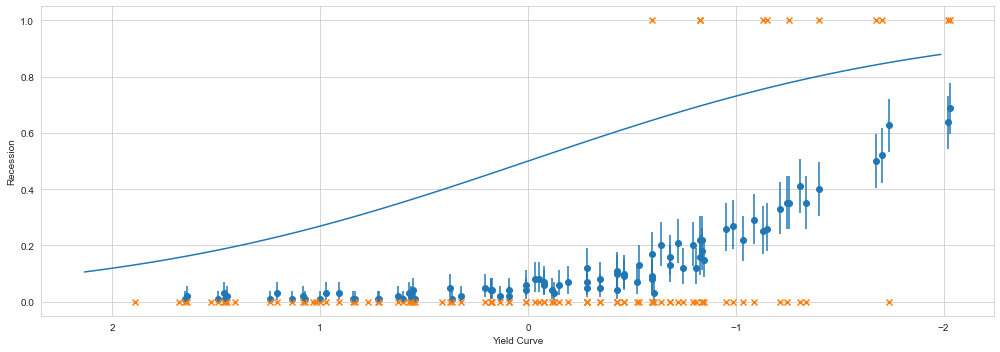

In [61]:
def invlogit(x):
    return np.exp(x) / (1 + np.exp(x))
x = X_test.yield_curve

fig, ax = plt.subplots(figsize=(14, 5))

β = stats.beta((ppc['y'] == 1).sum(axis=0), (ppc['y'] == 0).sum(axis=0))

# estimated probability
ax.scatter(x=x, y=β.mean())

# error bars on the estimate
plt.vlines(x, *β.interval(0.95))

# actual outcomes
ax.scatter(x=x, y=y_test, marker='x')

# True probabilities
x_ = np.linspace(x.min()*1.05, x.max()*1.05, num=100)
ax.plot(-x_, invlogit(x_), linestyle='-')

ax.set_xlabel('Yield Curve')
ax.set_ylabel('Recession')
ax.invert_xaxis()
fig.tight_layout()

In [62]:
# MCMC Sampler Animation
# setup

# Number of MCMC iteration to animate.
burnin = 1000
samples = 1000

var1 = 'yield_curve'
var1_range = (trace_df[var1].min() * .95, trace_df[var1].max() * 1.05)

var2 = 'sentiment'
var2_range = (trace_df[var2].min() * .95, trace_df[var2].max() * 1.05)
Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)
with pm.Model() as logistic_model:
    pm.glm.GLM.from_formula(formula=full_model, data=data,
                            family=pm.glm.families.Binomial())

The glm module is deprecated and will be removed in version 4.0
We recommend to instead use Bambi https://bambinos.github.io/bambi/


In [63]:
# NUTS samples
def init():
    for line in lines:
        line.set_data([], [])
    return lines

def animate(i):
    trace = trace_df.iloc[:i+1]
    idx = list(range(len(trace)))
    line1.set_data(trace[var1].iloc[::-1], idx)
    line2.set_data(idx, trace[var2].iloc[::-1])
    line3.set_data(trace[var1], trace[var2])
    line4.set_data(trace[var1], trace[var2])
    line5.set_data([trace[var1].iloc[-1], trace[var1].iloc[-1]], [trace[var2].iloc[-1], var2_range[1]])
    line6.set_data([trace[var1].iloc[-1], var1_range[1]], [trace[var2].iloc[-1], trace[var2].iloc[-1]])
    return lines
with logistic_model:
    nuts_trace = pm.sample(draws=samples, tune=burnin, init='adapt_diag', chains=1)
    trace_df = pm.trace_to_dataframe(nuts_trace)
trace_df.to_csv('trace.csv', index=False)
trace_df = pd.read_csv('trace.csv')
print(trace_df.info())

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sentiment, financial_conditions, leverage, yield_curve, Intercept]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 5 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Intercept             1000 non-null   float64
 1   yield_curve           1000 non-null   float64
 2   leverage              1000 non-null   float64
 3   financial_conditions  1000 non-null   float64
 4   sentiment             1000 non-null   float64
dtypes: float64(5)
memory usage: 39.2 KB
None


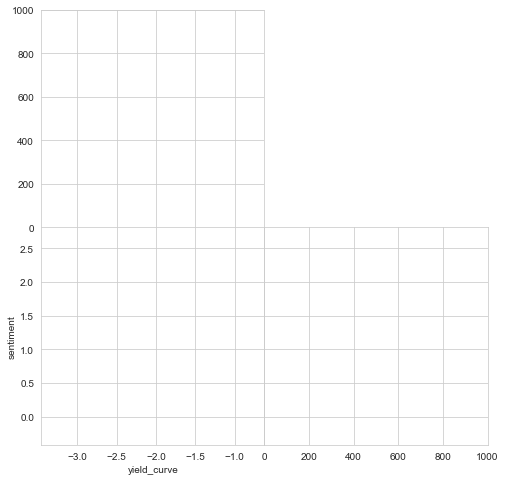

In [64]:
fig = plt.figure(figsize=(8, 8))
ax1 = fig.add_subplot(221, xlim=var1_range, ylim=(0, samples))
ax2 = fig.add_subplot(224, xlim=(0, samples), ylim=var2_range)
ax3 = fig.add_subplot(223, xlim=var1_range, ylim=var2_range, xlabel=var1, ylabel=var2)

fig.subplots_adjust(wspace=0.0, hspace=0.0)
line1, = ax1.plot([], [], lw=1)
line2, = ax2.plot([], [], lw=1)
line3, = ax3.plot([], [], 'o', lw=2, alpha=.1)
line4, = ax3.plot([], [], lw=1, alpha=.3)
line5, = ax3.plot([], [], 'k', lw=1)
line6, = ax3.plot([], [], 'k', lw=1)
ax1.set_xticklabels([])
ax2.set_yticklabels([])
lines = [line1, line2, line3, line4, line5, line6]

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=samples, interval=5, blit=True);

In [65]:
# save
anim.save('nuts.mp4', writer=writer)
# or display; either requres ffmpeg installation
# HTML(anim.to_html5_video())

In [66]:
# Metropolis-Hastings samples
with logistic_model:
    step = pm.Metropolis()
    mh_trace = pm.sample(draws=samples, tune=burnin, step=step, chains=1)
    trace_df = pm.trace_to_dataframe(mh_trace)

Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [sentiment]
>Metropolis: [financial_conditions]
>Metropolis: [leverage]
>Metropolis: [yield_curve]
>Metropolis: [Intercept]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 3 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


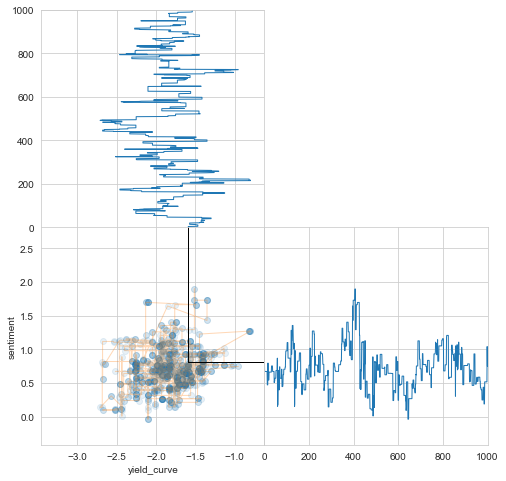

In [67]:
fig = plt.figure(figsize=(8, 8))
ax1 = fig.add_subplot(221, xlim=var1_range, ylim=(0, samples))
ax2 = fig.add_subplot(224, xlim=(0, samples), ylim=var2_range)
ax3 = fig.add_subplot(223, xlim=var1_range, ylim=var2_range, xlabel=var1, ylabel=var2)

fig.subplots_adjust(wspace=0.0, hspace=0.0)
line1, = ax1.plot([], [], lw=1)
line2, = ax2.plot([], [], lw=1)
line3, = ax3.plot([], [], 'o', lw=2, alpha=.1)
line4, = ax3.plot([], [], lw=1, alpha=.3)
line5, = ax3.plot([], [], 'k', lw=1)
line6, = ax3.plot([], [], 'k', lw=1)
ax1.set_xticklabels([])
ax2.set_yticklabels([])
lines = [line1, line2, line3, line4, line5, line6]

def init():
    for line in lines:
        line.set_data([], [])
    return lines

def animate(i):
    trace = trace_df.iloc[:i+1]
    idx = list(range(len(trace)))
    line1.set_data(trace[var1].iloc[::-1], idx)
    line2.set_data(idx, trace[var2].iloc[::-1])
    line3.set_data(trace[var1], trace[var2])
    line4.set_data(trace[var1], trace[var2])
    line5.set_data([trace[var1].iloc[-1], trace[var1].iloc[-1]], [trace[var2].iloc[-1], var2_range[1]])
    line6.set_data([trace[var1].iloc[-1], var1_range[1]], [trace[var2].iloc[-1], trace[var2].iloc[-1]])
    return lines

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=samples, interval=5, blit=True)

HTML(anim.to_html5_video())